In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
from tqdm import tqdm

In [4]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
casp_protein_id = 'T1027'   # 6ya2
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


5041.1127765100155 3016.77983666189 5502.113555955339
0.0 25.216 24.93199999999999


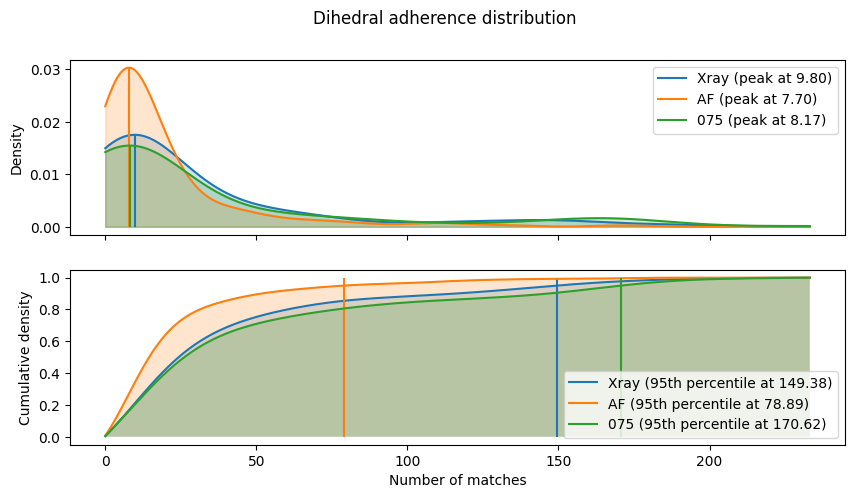

In [150]:
from scipy.stats import gaussian_kde

xray_phi_psi = da.xray_phi_psi.dropna().copy()
af_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna().copy()
results = da.grouped_preds.set_index('protein_id')
xray_phi_psi['rmsd'] = 0
af_phi_psi['rmsd'] = results.loc[da.alphafold_id].RMS_CA

other_id = da.protein_ids[0]
other_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == other_id].dropna().copy()
other_phi_psi['rmsd'] = results.loc[other_id].RMS_CA

print(xray_phi_psi.da.sum(), af_phi_psi.da.sum(), other_phi_psi.da.sum())
print(xray_phi_psi.rmsd.mean(), af_phi_psi.rmsd.mean(), other_phi_psi.rmsd.mean())

df = pd.concat([
    xray_phi_psi, 
    af_phi_psi.drop('da_na', axis=1),
    other_phi_psi.drop('da_na', axis=1)
])

def get_probs(x, da):
    kde = gaussian_kde(da)
    p = kde(x)
    c = np.cumsum(p) / np.sum(p)
    peak = x[np.argmax(p)]
    return p, c, peak

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 5))
x = np.linspace(0, df.da.max(), 1000)

def plot(df, label, color):
    p, c, peak = get_probs(x, df.da)
    axes[0].plot(x, p, color=color, label=f'{label} (peak at {peak:.2f})')
    axes[0].fill_between(x, 0, p, alpha=0.2, color=color)
    axes[0].vlines(peak, 0, p.max(), color=color)
    perc = x[np.argmax(c > 0.95)]
    axes[1].plot(x, c, color=color, label=f'{label} (95th percentile at {perc:.2f})')
    axes[1].vlines(perc, 0, 1, color=color)
    axes[1].fill_between(x, 0, c, alpha=0.2)

colors = sns.color_palette("tab10")
plot(xray_phi_psi, 'Xray', colors[0])
plot(af_phi_psi, 'AF', colors[1])
plot(other_phi_psi, other_id[7:10], colors[2])
axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Number of matches')
axes[1].set_ylabel('Cumulative density')
# axes[0].set_xlim(0, 5000)
# axes[1].set_xlim(0, 5000)
fig.suptitle('Dihedral adherence distribution')
plt.show()

Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
Slope: 0.5609237437315117, Intercept: -14.534285881345971


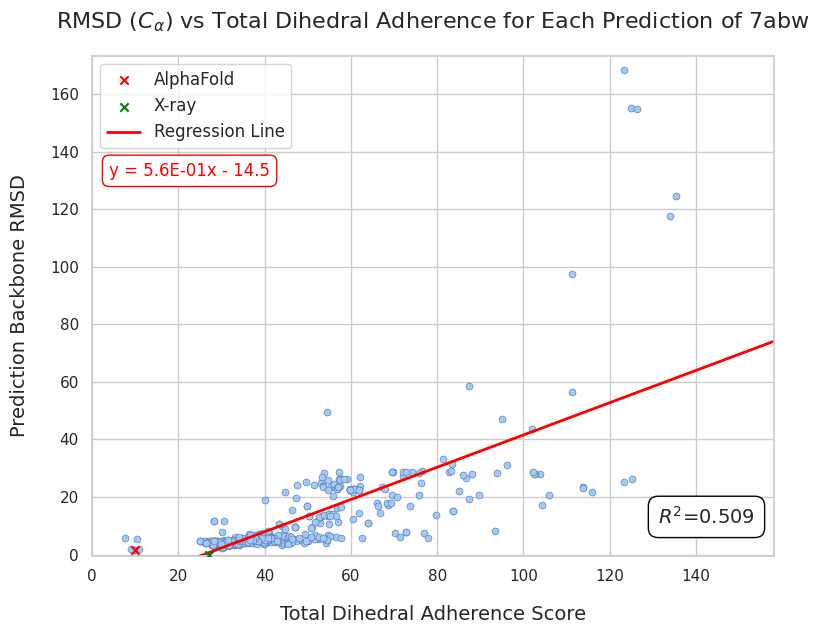

In [47]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

da = DihedralAdherence(proteins[5], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
da.load_results_da()
da.plot_da_vs_rmsd_simple()

In [48]:
rmsds = []
scores = []
thresh = 158.16
for id in da.protein_ids:
    df = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
    rmsd = da.grouped_preds.set_index('protein_id').loc[id].RMS_CA
    # if rmsd > 20:
        # continue
    if df.shape[0] == 0:
        continue
    score = (df.da < thresh).sum() / df.shape[0]
    scores.append(score)
    rmsds.append(rmsd)

0.6416289900575801


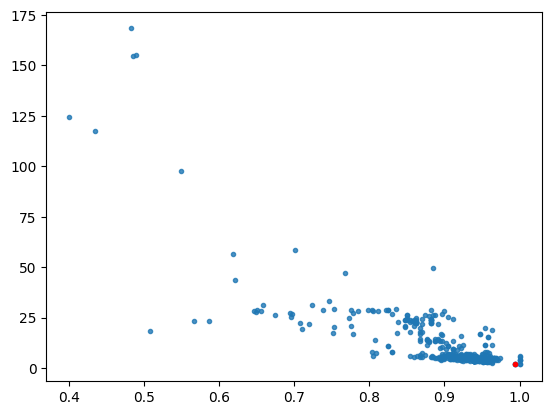

In [49]:
df = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna()
# p, c, peak = get_probs(x, df.da)
score = (df.da < thresh).sum() / df.shape[0]
rmsd = da.grouped_preds.set_index('protein_id').loc[da.alphafold_id].RMS_CA
model = stats.linregress(scores, rmsds)
print(model.rvalue**2)
plt.scatter(scores, rmsds, marker='.', alpha=0.8)
plt.scatter(score, rmsd, color='red', marker='.')
plt.show()

In [ ]:
from scipy import stats
# fit linregr to each and find best threshold
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1027', 'T1082', 'T1058', 'T1049', 'T1030', 'T1056']
results = []
for thresh in np.linspace(0, 250, 50):
    for protein in proteins:
        print(f'Protein {protein} threshold {thresh}')
        da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='kde_af')
        da.load_results_da()
        scores = []
        rmsds = []
        pbar = tqdm(da.protein_ids)
        pbar.set_description(f'Protein {protein} Threshold {thresh}')
        for id in pbar:
            preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
            if preds.shape[0] == 0:
                continue
            rmsd = da.grouped_preds[da.grouped_preds.protein_id == id].RMS_CA.values
            if len(rmsd) == 0:
                continue
            rmsd = rmsd[0]
            score = (preds.da < thresh).sum() / preds.shape[0]
            scores.append(score)
            rmsds.append(rmsd)
        model = stats.linregress(rmsds, scores)
        results.append((protein, thresh, model.slope, model.intercept, model.rvalue**2, model.pvalue))

    results_df = pd.DataFrame(results, columns=['protein', 'threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
    results_df.to_csv('results_threshold.csv', index=False)

results = pd.DataFrame(results, columns=['protein', 'threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
results.to_csv('results_threshold.csv', index=False)

In [5]:
results = pd.read_csv('results_threshold.csv')
results['threshold'] = results['threshold'].round(2)
results.groupby('threshold').describe().sort_values(('rsquared', 'mean'), ascending=False)['rsquared'].head(20)

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
158.16,7.0,0.382068,0.140668,0.233271,0.294025,0.329946,0.447491,0.628226
163.27,7.0,0.381303,0.144716,0.213115,0.297737,0.342003,0.435568,0.647396
147.96,7.0,0.373541,0.134938,0.250156,0.267280,0.318503,0.461769,0.588032
168.37,7.0,0.373535,0.154781,0.202072,0.274724,0.359027,0.418030,0.668136
153.06,7.0,0.373405,0.138940,0.249395,0.264097,0.317955,0.457323,0.603645
142.86,7.0,0.367318,0.129633,0.242108,0.268920,0.310628,0.459431,0.561786
137.76,7.0,0.358152,0.132526,0.225611,0.261493,0.298345,0.457669,0.544784
173.47,7.0,0.355859,0.163604,0.170348,0.253139,0.365631,0.387991,0.672777
132.65,7.0,0.349766,0.132299,0.211811,0.249196,0.301875,0.453185,0.529917


In [47]:
results[results.threshold == 158.16]

,protein,threshold,slope,intercept,rsquared,pvalue
217,T1024,158.16,-0.002895,0.985321,0.329946,7.792327e-44
218,T1027,158.16,-0.005977,0.873735,0.262962,6.017007e-34
219,T1082,158.16,-0.022330,1.034329,0.507824,2.002165e-69
220,T1058,158.16,-0.004052,0.931994,0.628226,3.491656e-102
221,T1049,158.16,-0.008304,0.928867,0.325088,6.714339e-40
222,T1030,158.16,-0.002749,0.977131,0.387158,6.702503e-50
223,T1056,158.16,-0.008922,0.917847,0.233271,1.148845e-28


# Combined

In [48]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']


proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1027', 'T1082', 'T1058', 'T1049', 'T1030', 'T1056']
results = []
for thresh in np.linspace(0, 250, 50):
    thresh = round(thresh, 2)
    scores = []
    rmsds = []
    protein_ids = []
    for protein in proteins:
        da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                            mode='kde_af')
        da.load_results_da()
        pbar = tqdm(da.protein_ids)
        pbar.set_description(f'Protein {protein} Threshold {thresh}')
        for id in pbar:
            preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
            if preds.shape[0] == 0:
                continue
            rmsd = da.grouped_preds[da.grouped_preds.protein_id == id].RMS_CA.values
            if len(rmsd) == 0:
                continue
            rmsd = rmsd[0]
            score = (preds.da < thresh).sum() / preds.shape[0]
            scores.append(score)
            rmsds.append(rmsd)
            protein_ids.append(protein)
        
    model = stats.linregress(rmsds, scores)
    results.append((thresh, model.slope, model.intercept, model.rvalue**2, model.pvalue))

results_df = pd.DataFrame(results, columns=['threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
results_df.to_csv('results_threshold_combined.csv', index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 0.0: 100%|██████████| 484/484 [00:02<00:00, 164.60it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 0.0: 100%|██████████| 486/486 [00:01<00:00, 382.07it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 0.0: 100%|██████████| 448/448 [00:00<00:00, 667.35it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 0.0: 100%|██████████| 474/474 [00:02<00:00, 180.78it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 0.0: 100%|██████████| 447/447 [00:00<00:00, 477.71it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 0.0: 100%|██████████| 462/462 [00:01<00:00, 252.58it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 0.0: 100%|██████████| 467/467 [00:01<00:00, 350.77it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 5.1: 100%|██████████| 484/484 [00:02<00:00, 162.87it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 5.1: 100%|██████████| 486/486 [00:01<00:00, 378.39it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 5.1: 100%|██████████| 448/448 [00:00<00:00, 632.27it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 5.1: 100%|██████████| 474/474 [00:02<00:00, 177.52it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 5.1: 100%|██████████| 447/447 [00:00<00:00, 474.20it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 5.1: 100%|██████████| 462/462 [00:01<00:00, 250.56it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 5.1: 100%|██████████| 467/467 [00:01<00:00, 361.26it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 10.2: 100%|██████████| 484/484 [00:02<00:00, 166.83it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 10.2: 100%|██████████| 486/486 [00:01<00:00, 382.60it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 10.2: 100%|██████████| 448/448 [00:00<00:00, 671.24it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 10.2: 100%|██████████| 474/474 [00:02<00:00, 181.89it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 10.2: 100%|██████████| 447/447 [00:00<00:00, 475.69it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 10.2: 100%|██████████| 462/462 [00:01<00:00, 248.24it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 10.2: 100%|██████████| 467/467 [00:01<00:00, 348.62it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 15.31: 100%|██████████| 484/484 [00:02<00:00, 168.47it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 15.31: 100%|██████████| 486/486 [00:01<00:00, 384.45it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 15.31: 100%|██████████| 448/448 [00:00<00:00, 679.98it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 15.31: 100%|██████████| 474/474 [00:02<00:00, 180.91it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 15.31: 100%|██████████| 447/447 [00:00<00:00, 482.83it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 15.31: 100%|██████████| 462/462 [00:01<00:00, 259.28it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 15.31: 100%|██████████| 467/467 [00:01<00:00, 356.29it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 20.41: 100%|██████████| 484/484 [00:02<00:00, 166.01it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 20.41: 100%|██████████| 486/486 [00:01<00:00, 379.35it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 20.41: 100%|██████████| 448/448 [00:00<00:00, 670.92it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 20.41: 100%|██████████| 474/474 [00:02<00:00, 180.59it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 20.41: 100%|██████████| 447/447 [00:00<00:00, 480.33it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 20.41: 100%|██████████| 462/462 [00:01<00:00, 257.56it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 20.41: 100%|██████████| 467/467 [00:01<00:00, 353.89it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 25.51: 100%|██████████| 484/484 [00:02<00:00, 163.99it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 25.51: 100%|██████████| 486/486 [00:01<00:00, 379.64it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 25.51: 100%|██████████| 448/448 [00:00<00:00, 671.57it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 25.51: 100%|██████████| 474/474 [00:02<00:00, 177.93it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 25.51: 100%|██████████| 447/447 [00:00<00:00, 485.69it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 25.51: 100%|██████████| 462/462 [00:01<00:00, 251.99it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 25.51: 100%|██████████| 467/467 [00:01<00:00, 368.55it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 30.61: 100%|██████████| 484/484 [00:02<00:00, 166.40it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 30.61: 100%|██████████| 486/486 [00:01<00:00, 374.14it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 30.61: 100%|██████████| 448/448 [00:00<00:00, 648.18it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 30.61: 100%|██████████| 474/474 [00:02<00:00, 179.19it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 30.61: 100%|██████████| 447/447 [00:00<00:00, 463.96it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 30.61: 100%|██████████| 462/462 [00:01<00:00, 251.53it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 30.61: 100%|██████████| 467/467 [00:01<00:00, 358.21it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 35.71: 100%|██████████| 484/484 [00:02<00:00, 164.48it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 35.71: 100%|██████████| 486/486 [00:01<00:00, 366.85it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 35.71: 100%|██████████| 448/448 [00:00<00:00, 665.85it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 35.71: 100%|██████████| 474/474 [00:02<00:00, 176.54it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 35.71: 100%|██████████| 447/447 [00:00<00:00, 461.78it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 35.71: 100%|██████████| 462/462 [00:01<00:00, 253.73it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 35.71: 100%|██████████| 467/467 [00:01<00:00, 353.50it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 40.82: 100%|██████████| 484/484 [00:02<00:00, 166.04it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 40.82: 100%|██████████| 486/486 [00:01<00:00, 377.04it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 40.82: 100%|██████████| 448/448 [00:00<00:00, 665.72it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 40.82: 100%|██████████| 474/474 [00:02<00:00, 177.99it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 40.82: 100%|██████████| 447/447 [00:00<00:00, 472.28it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 40.82: 100%|██████████| 462/462 [00:01<00:00, 252.28it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 40.82: 100%|██████████| 467/467 [00:01<00:00, 363.13it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 45.92: 100%|██████████| 484/484 [00:02<00:00, 169.31it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 45.92: 100%|██████████| 486/486 [00:01<00:00, 387.56it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 45.92: 100%|██████████| 448/448 [00:00<00:00, 657.75it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 45.92: 100%|██████████| 474/474 [00:02<00:00, 182.53it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 45.92: 100%|██████████| 447/447 [00:00<00:00, 487.09it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 45.92: 100%|██████████| 462/462 [00:01<00:00, 253.24it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 45.92: 100%|██████████| 467/467 [00:01<00:00, 360.90it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 51.02: 100%|██████████| 484/484 [00:02<00:00, 168.07it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 51.02: 100%|██████████| 486/486 [00:01<00:00, 385.06it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 51.02: 100%|██████████| 448/448 [00:00<00:00, 669.65it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 51.02: 100%|██████████| 474/474 [00:02<00:00, 182.35it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 51.02: 100%|██████████| 447/447 [00:00<00:00, 465.81it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 51.02: 100%|██████████| 462/462 [00:01<00:00, 255.88it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 51.02: 100%|██████████| 467/467 [00:01<00:00, 358.61it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 56.12: 100%|██████████| 484/484 [00:02<00:00, 168.08it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 56.12: 100%|██████████| 486/486 [00:01<00:00, 381.02it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 56.12: 100%|██████████| 448/448 [00:00<00:00, 662.38it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 56.12: 100%|██████████| 474/474 [00:02<00:00, 185.11it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 56.12: 100%|██████████| 447/447 [00:00<00:00, 476.37it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 56.12: 100%|██████████| 462/462 [00:01<00:00, 257.11it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 56.12: 100%|██████████| 467/467 [00:01<00:00, 363.40it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 61.22: 100%|██████████| 484/484 [00:02<00:00, 167.79it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 61.22: 100%|██████████| 486/486 [00:01<00:00, 386.09it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 61.22: 100%|██████████| 448/448 [00:00<00:00, 668.03it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 61.22: 100%|██████████| 474/474 [00:02<00:00, 180.35it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 61.22: 100%|██████████| 447/447 [00:00<00:00, 474.24it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 61.22: 100%|██████████| 462/462 [00:01<00:00, 254.97it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 61.22: 100%|██████████| 467/467 [00:01<00:00, 359.57it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 66.33: 100%|██████████| 484/484 [00:02<00:00, 169.40it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 66.33: 100%|██████████| 486/486 [00:01<00:00, 383.65it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 66.33: 100%|██████████| 448/448 [00:00<00:00, 663.44it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 66.33: 100%|██████████| 474/474 [00:02<00:00, 180.47it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 66.33: 100%|██████████| 447/447 [00:00<00:00, 485.97it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 66.33: 100%|██████████| 462/462 [00:01<00:00, 255.60it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 66.33: 100%|██████████| 467/467 [00:01<00:00, 360.50it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 71.43: 100%|██████████| 484/484 [00:02<00:00, 165.66it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 71.43: 100%|██████████| 486/486 [00:01<00:00, 367.79it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 71.43: 100%|██████████| 448/448 [00:00<00:00, 620.79it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 71.43: 100%|██████████| 474/474 [00:02<00:00, 181.45it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 71.43: 100%|██████████| 447/447 [00:00<00:00, 477.24it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 71.43: 100%|██████████| 462/462 [00:01<00:00, 250.61it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 71.43: 100%|██████████| 467/467 [00:01<00:00, 355.20it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 76.53: 100%|██████████| 484/484 [00:02<00:00, 166.47it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 76.53: 100%|██████████| 486/486 [00:01<00:00, 374.70it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 76.53: 100%|██████████| 448/448 [00:00<00:00, 662.54it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 76.53: 100%|██████████| 474/474 [00:02<00:00, 180.22it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 76.53: 100%|██████████| 447/447 [00:00<00:00, 480.94it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 76.53: 100%|██████████| 462/462 [00:01<00:00, 253.93it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 76.53: 100%|██████████| 467/467 [00:01<00:00, 357.08it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 81.63: 100%|██████████| 484/484 [00:02<00:00, 167.80it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 81.63: 100%|██████████| 486/486 [00:01<00:00, 367.89it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 81.63: 100%|██████████| 448/448 [00:00<00:00, 671.01it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 81.63: 100%|██████████| 474/474 [00:02<00:00, 182.08it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 81.63: 100%|██████████| 447/447 [00:00<00:00, 473.57it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 81.63: 100%|██████████| 462/462 [00:01<00:00, 257.41it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 81.63: 100%|██████████| 467/467 [00:01<00:00, 364.73it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 86.73: 100%|██████████| 484/484 [00:02<00:00, 169.23it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 86.73: 100%|██████████| 486/486 [00:01<00:00, 380.65it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 86.73: 100%|██████████| 448/448 [00:00<00:00, 635.43it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 86.73: 100%|██████████| 474/474 [00:02<00:00, 183.12it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 86.73: 100%|██████████| 447/447 [00:00<00:00, 465.56it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 86.73: 100%|██████████| 462/462 [00:01<00:00, 250.96it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 86.73: 100%|██████████| 467/467 [00:01<00:00, 350.62it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 91.84: 100%|██████████| 484/484 [00:02<00:00, 165.99it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 91.84: 100%|██████████| 486/486 [00:01<00:00, 370.59it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 91.84: 100%|██████████| 448/448 [00:00<00:00, 644.77it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 91.84: 100%|██████████| 474/474 [00:02<00:00, 180.18it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 91.84: 100%|██████████| 447/447 [00:00<00:00, 479.32it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 91.84: 100%|██████████| 462/462 [00:01<00:00, 255.42it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 91.84: 100%|██████████| 467/467 [00:01<00:00, 357.19it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 96.94: 100%|██████████| 484/484 [00:02<00:00, 169.09it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 96.94: 100%|██████████| 486/486 [00:01<00:00, 384.80it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 96.94: 100%|██████████| 448/448 [00:00<00:00, 665.19it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 96.94: 100%|██████████| 474/474 [00:02<00:00, 182.50it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 96.94: 100%|██████████| 447/447 [00:00<00:00, 476.86it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 96.94: 100%|██████████| 462/462 [00:01<00:00, 253.77it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 96.94: 100%|██████████| 467/467 [00:01<00:00, 369.65it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 102.04: 100%|██████████| 484/484 [00:02<00:00, 164.13it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 102.04: 100%|██████████| 486/486 [00:01<00:00, 377.34it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 102.04: 100%|██████████| 448/448 [00:00<00:00, 675.99it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 102.04: 100%|██████████| 474/474 [00:02<00:00, 181.73it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 102.04: 100%|██████████| 447/447 [00:00<00:00, 477.55it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 102.04: 100%|██████████| 462/462 [00:01<00:00, 250.42it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 102.04: 100%|██████████| 467/467 [00:01<00:00, 364.57it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 107.14: 100%|██████████| 484/484 [00:02<00:00, 165.51it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 107.14: 100%|██████████| 486/486 [00:01<00:00, 371.58it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 107.14: 100%|██████████| 448/448 [00:00<00:00, 666.86it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 107.14: 100%|██████████| 474/474 [00:02<00:00, 178.57it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 107.14: 100%|██████████| 447/447 [00:00<00:00, 471.22it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 107.14: 100%|██████████| 462/462 [00:01<00:00, 252.90it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 107.14: 100%|██████████| 467/467 [00:01<00:00, 364.23it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 112.24: 100%|██████████| 484/484 [00:02<00:00, 164.19it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 112.24: 100%|██████████| 486/486 [00:01<00:00, 369.48it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 112.24: 100%|██████████| 448/448 [00:00<00:00, 646.46it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 112.24: 100%|██████████| 474/474 [00:02<00:00, 178.24it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 112.24: 100%|██████████| 447/447 [00:00<00:00, 449.31it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 112.24: 100%|██████████| 462/462 [00:01<00:00, 249.02it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 112.24: 100%|██████████| 467/467 [00:01<00:00, 350.69it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 117.35: 100%|██████████| 484/484 [00:02<00:00, 168.45it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 117.35: 100%|██████████| 486/486 [00:01<00:00, 385.27it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 117.35: 100%|██████████| 448/448 [00:00<00:00, 671.80it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 117.35: 100%|██████████| 474/474 [00:02<00:00, 182.52it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 117.35: 100%|██████████| 447/447 [00:00<00:00, 469.67it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 117.35: 100%|██████████| 462/462 [00:01<00:00, 252.47it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 117.35: 100%|██████████| 467/467 [00:01<00:00, 366.05it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 122.45: 100%|██████████| 484/484 [00:02<00:00, 169.04it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 122.45: 100%|██████████| 486/486 [00:01<00:00, 384.63it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 122.45: 100%|██████████| 448/448 [00:00<00:00, 670.14it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 122.45: 100%|██████████| 474/474 [00:02<00:00, 181.72it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 122.45: 100%|██████████| 447/447 [00:00<00:00, 477.45it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 122.45: 100%|██████████| 462/462 [00:01<00:00, 259.54it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 122.45: 100%|██████████| 467/467 [00:01<00:00, 361.91it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 127.55: 100%|██████████| 484/484 [00:02<00:00, 168.66it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 127.55: 100%|██████████| 486/486 [00:01<00:00, 388.70it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 127.55: 100%|██████████| 448/448 [00:00<00:00, 670.86it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 127.55: 100%|██████████| 474/474 [00:02<00:00, 185.19it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 127.55: 100%|██████████| 447/447 [00:00<00:00, 484.49it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 127.55: 100%|██████████| 462/462 [00:01<00:00, 251.28it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 127.55: 100%|██████████| 467/467 [00:01<00:00, 358.65it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 132.65: 100%|██████████| 484/484 [00:02<00:00, 161.53it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 132.65: 100%|██████████| 486/486 [00:01<00:00, 367.61it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 132.65: 100%|██████████| 448/448 [00:00<00:00, 600.75it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 132.65: 100%|██████████| 474/474 [00:02<00:00, 184.42it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 132.65: 100%|██████████| 447/447 [00:00<00:00, 474.61it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 132.65: 100%|██████████| 462/462 [00:01<00:00, 255.71it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 132.65: 100%|██████████| 467/467 [00:01<00:00, 356.41it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 137.76: 100%|██████████| 484/484 [00:02<00:00, 168.26it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 137.76: 100%|██████████| 486/486 [00:01<00:00, 378.39it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 137.76: 100%|██████████| 448/448 [00:00<00:00, 631.47it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 137.76: 100%|██████████| 474/474 [00:02<00:00, 179.72it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 137.76: 100%|██████████| 447/447 [00:00<00:00, 473.60it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 137.76: 100%|██████████| 462/462 [00:01<00:00, 254.40it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 137.76: 100%|██████████| 467/467 [00:01<00:00, 360.29it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 142.86: 100%|██████████| 484/484 [00:02<00:00, 165.13it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 142.86: 100%|██████████| 486/486 [00:01<00:00, 371.99it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 142.86: 100%|██████████| 448/448 [00:00<00:00, 664.31it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 142.86: 100%|██████████| 474/474 [00:02<00:00, 179.41it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 142.86: 100%|██████████| 447/447 [00:00<00:00, 470.80it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 142.86: 100%|██████████| 462/462 [00:01<00:00, 256.56it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 142.86: 100%|██████████| 467/467 [00:01<00:00, 363.35it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 147.96: 100%|██████████| 484/484 [00:02<00:00, 166.43it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 147.96: 100%|██████████| 486/486 [00:01<00:00, 385.87it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 147.96: 100%|██████████| 448/448 [00:00<00:00, 656.14it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 147.96: 100%|██████████| 474/474 [00:02<00:00, 176.13it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 147.96: 100%|██████████| 447/447 [00:00<00:00, 476.67it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 147.96: 100%|██████████| 462/462 [00:01<00:00, 256.64it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 147.96: 100%|██████████| 467/467 [00:01<00:00, 367.70it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 153.06: 100%|██████████| 484/484 [00:02<00:00, 166.69it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 153.06: 100%|██████████| 486/486 [00:01<00:00, 386.78it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 153.06: 100%|██████████| 448/448 [00:00<00:00, 663.56it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 153.06: 100%|██████████| 474/474 [00:02<00:00, 182.49it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 153.06: 100%|██████████| 447/447 [00:00<00:00, 488.55it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 153.06: 100%|██████████| 462/462 [00:01<00:00, 256.95it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 153.06: 100%|██████████| 467/467 [00:01<00:00, 359.82it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 158.16: 100%|██████████| 484/484 [00:02<00:00, 167.52it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 158.16: 100%|██████████| 486/486 [00:01<00:00, 385.09it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 158.16: 100%|██████████| 448/448 [00:00<00:00, 670.63it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 158.16: 100%|██████████| 474/474 [00:02<00:00, 176.93it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 158.16: 100%|██████████| 447/447 [00:00<00:00, 474.63it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 158.16: 100%|██████████| 462/462 [00:01<00:00, 248.17it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 158.16: 100%|██████████| 467/467 [00:01<00:00, 357.14it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 163.27: 100%|██████████| 484/484 [00:02<00:00, 166.02it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 163.27: 100%|██████████| 486/486 [00:01<00:00, 380.57it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 163.27: 100%|██████████| 448/448 [00:00<00:00, 656.41it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 163.27: 100%|██████████| 474/474 [00:02<00:00, 178.72it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 163.27: 100%|██████████| 447/447 [00:00<00:00, 469.05it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 163.27: 100%|██████████| 462/462 [00:01<00:00, 251.61it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 163.27: 100%|██████████| 467/467 [00:01<00:00, 364.22it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 168.37: 100%|██████████| 484/484 [00:02<00:00, 168.13it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 168.37: 100%|██████████| 486/486 [00:01<00:00, 371.74it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 168.37: 100%|██████████| 448/448 [00:00<00:00, 669.83it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 168.37: 100%|██████████| 474/474 [00:02<00:00, 182.68it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 168.37: 100%|██████████| 447/447 [00:00<00:00, 474.93it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 168.37: 100%|██████████| 462/462 [00:01<00:00, 256.81it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 168.37: 100%|██████████| 467/467 [00:01<00:00, 350.20it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 173.47: 100%|██████████| 484/484 [00:02<00:00, 167.39it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 173.47: 100%|██████████| 486/486 [00:01<00:00, 388.61it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 173.47: 100%|██████████| 448/448 [00:00<00:00, 671.94it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 173.47: 100%|██████████| 474/474 [00:02<00:00, 181.35it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 173.47: 100%|██████████| 447/447 [00:00<00:00, 479.68it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 173.47: 100%|██████████| 462/462 [00:01<00:00, 253.89it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 173.47: 100%|██████████| 467/467 [00:01<00:00, 347.58it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 178.57: 100%|██████████| 484/484 [00:02<00:00, 168.52it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 178.57: 100%|██████████| 486/486 [00:01<00:00, 373.00it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 178.57: 100%|██████████| 448/448 [00:00<00:00, 672.92it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 178.57: 100%|██████████| 474/474 [00:02<00:00, 186.20it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 178.57: 100%|██████████| 447/447 [00:00<00:00, 469.17it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 178.57: 100%|██████████| 462/462 [00:01<00:00, 249.29it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 178.57: 100%|██████████| 467/467 [00:01<00:00, 354.95it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 183.67: 100%|██████████| 484/484 [00:02<00:00, 165.78it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 183.67: 100%|██████████| 486/486 [00:01<00:00, 382.95it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 183.67: 100%|██████████| 448/448 [00:00<00:00, 645.18it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 183.67: 100%|██████████| 474/474 [00:02<00:00, 179.23it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 183.67: 100%|██████████| 447/447 [00:00<00:00, 485.22it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 183.67: 100%|██████████| 462/462 [00:01<00:00, 256.51it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 183.67: 100%|██████████| 467/467 [00:01<00:00, 365.17it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 188.78: 100%|██████████| 484/484 [00:02<00:00, 162.54it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 188.78: 100%|██████████| 486/486 [00:01<00:00, 390.06it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 188.78: 100%|██████████| 448/448 [00:00<00:00, 668.05it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 188.78: 100%|██████████| 474/474 [00:02<00:00, 182.77it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 188.78: 100%|██████████| 447/447 [00:00<00:00, 490.45it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 188.78: 100%|██████████| 462/462 [00:01<00:00, 260.92it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 188.78: 100%|██████████| 467/467 [00:01<00:00, 364.48it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 193.88: 100%|██████████| 484/484 [00:02<00:00, 169.52it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 193.88: 100%|██████████| 486/486 [00:01<00:00, 398.54it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 193.88: 100%|██████████| 448/448 [00:00<00:00, 676.30it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 193.88: 100%|██████████| 474/474 [00:02<00:00, 186.03it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 193.88: 100%|██████████| 447/447 [00:00<00:00, 491.18it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 193.88: 100%|██████████| 462/462 [00:01<00:00, 256.66it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 193.88: 100%|██████████| 467/467 [00:01<00:00, 348.49it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 198.98: 100%|██████████| 484/484 [00:02<00:00, 163.02it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 198.98: 100%|██████████| 486/486 [00:01<00:00, 381.92it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 198.98: 100%|██████████| 448/448 [00:00<00:00, 654.60it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 198.98: 100%|██████████| 474/474 [00:02<00:00, 181.39it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 198.98: 100%|██████████| 447/447 [00:00<00:00, 479.10it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 198.98: 100%|██████████| 462/462 [00:01<00:00, 246.86it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 198.98: 100%|██████████| 467/467 [00:01<00:00, 352.02it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 204.08: 100%|██████████| 484/484 [00:02<00:00, 164.04it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 204.08: 100%|██████████| 486/486 [00:01<00:00, 377.93it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 204.08: 100%|██████████| 448/448 [00:00<00:00, 652.90it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 204.08: 100%|██████████| 474/474 [00:02<00:00, 180.15it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 204.08: 100%|██████████| 447/447 [00:00<00:00, 474.89it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 204.08: 100%|██████████| 462/462 [00:01<00:00, 255.27it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 204.08: 100%|██████████| 467/467 [00:01<00:00, 366.84it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 209.18: 100%|██████████| 484/484 [00:02<00:00, 169.14it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 209.18: 100%|██████████| 486/486 [00:01<00:00, 374.13it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 209.18: 100%|██████████| 448/448 [00:00<00:00, 643.96it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 209.18: 100%|██████████| 474/474 [00:02<00:00, 177.72it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 209.18: 100%|██████████| 447/447 [00:00<00:00, 462.31it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 209.18: 100%|██████████| 462/462 [00:01<00:00, 253.25it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 209.18: 100%|██████████| 467/467 [00:01<00:00, 357.98it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 214.29: 100%|██████████| 484/484 [00:02<00:00, 165.41it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 214.29: 100%|██████████| 486/486 [00:01<00:00, 384.77it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 214.29: 100%|██████████| 448/448 [00:00<00:00, 664.98it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 214.29: 100%|██████████| 474/474 [00:02<00:00, 185.17it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 214.29: 100%|██████████| 447/447 [00:00<00:00, 487.34it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 214.29: 100%|██████████| 462/462 [00:01<00:00, 259.26it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 214.29: 100%|██████████| 467/467 [00:01<00:00, 367.93it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 219.39: 100%|██████████| 484/484 [00:02<00:00, 166.02it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 219.39: 100%|██████████| 486/486 [00:01<00:00, 382.64it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 219.39: 100%|██████████| 448/448 [00:00<00:00, 668.92it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 219.39: 100%|██████████| 474/474 [00:02<00:00, 182.58it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 219.39: 100%|██████████| 447/447 [00:00<00:00, 482.83it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 219.39: 100%|██████████| 462/462 [00:01<00:00, 255.69it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 219.39: 100%|██████████| 467/467 [00:01<00:00, 357.14it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 224.49: 100%|██████████| 484/484 [00:02<00:00, 166.61it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 224.49: 100%|██████████| 486/486 [00:01<00:00, 380.12it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 224.49: 100%|██████████| 448/448 [00:00<00:00, 640.97it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 224.49: 100%|██████████| 474/474 [00:02<00:00, 173.47it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 224.49: 100%|██████████| 447/447 [00:00<00:00, 465.21it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 224.49: 100%|██████████| 462/462 [00:01<00:00, 258.51it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 224.49: 100%|██████████| 467/467 [00:01<00:00, 362.26it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 229.59: 100%|██████████| 484/484 [00:02<00:00, 167.24it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 229.59: 100%|██████████| 486/486 [00:01<00:00, 384.12it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 229.59: 100%|██████████| 448/448 [00:00<00:00, 660.45it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 229.59: 100%|██████████| 474/474 [00:02<00:00, 174.96it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 229.59: 100%|██████████| 447/447 [00:00<00:00, 470.41it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 229.59: 100%|██████████| 462/462 [00:01<00:00, 246.60it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 229.59: 100%|██████████| 467/467 [00:01<00:00, 335.86it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 234.69: 100%|██████████| 484/484 [00:02<00:00, 163.23it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 234.69: 100%|██████████| 486/486 [00:01<00:00, 361.23it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 234.69: 100%|██████████| 448/448 [00:00<00:00, 646.29it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 234.69: 100%|██████████| 474/474 [00:02<00:00, 177.32it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 234.69: 100%|██████████| 447/447 [00:00<00:00, 462.90it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 234.69: 100%|██████████| 462/462 [00:01<00:00, 255.13it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 234.69: 100%|██████████| 467/467 [00:01<00:00, 360.54it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 239.8: 100%|██████████| 484/484 [00:03<00:00, 161.23it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 239.8: 100%|██████████| 486/486 [00:01<00:00, 379.81it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 239.8: 100%|██████████| 448/448 [00:00<00:00, 637.56it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 239.8: 100%|██████████| 474/474 [00:02<00:00, 185.40it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 239.8: 100%|██████████| 447/447 [00:00<00:00, 479.45it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 239.8: 100%|██████████| 462/462 [00:01<00:00, 259.61it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 239.8: 100%|██████████| 467/467 [00:01<00:00, 356.34it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 244.9: 100%|██████████| 484/484 [00:02<00:00, 165.28it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 244.9: 100%|██████████| 486/486 [00:01<00:00, 372.96it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 244.9: 100%|██████████| 448/448 [00:00<00:00, 630.78it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 244.9: 100%|██████████| 474/474 [00:02<00:00, 173.86it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 244.9: 100%|██████████| 447/447 [00:00<00:00, 474.59it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 244.9: 100%|██████████| 462/462 [00:01<00:00, 248.36it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 244.9: 100%|██████████| 467/467 [00:01<00:00, 351.10it/s]


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024 Threshold 250.0: 100%|██████████| 484/484 [00:02<00:00, 168.20it/s]


Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 


Protein T1027 Threshold 250.0: 100%|██████████| 486/486 [00:01<00:00, 369.95it/s]


Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
No AlphaFold prediction found for 7cn6
No AlphaFold phi-psi data found


Protein T1082 Threshold 250.0: 100%|██████████| 448/448 [00:00<00:00, 644.66it/s]


Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
No AlphaFold phi-psi data found


Protein T1058 Threshold 250.0: 100%|██████████| 474/474 [00:02<00:00, 176.75it/s]


Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
No AlphaFold phi-psi data found


Protein T1049 Threshold 250.0: 100%|██████████| 447/447 [00:00<00:00, 470.07it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No AlphaFold phi-psi data found


Protein T1030 Threshold 250.0: 100%|██████████| 462/462 [00:01<00:00, 255.03it/s]


Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found


Protein T1056 Threshold 250.0: 100%|██████████| 467/467 [00:01<00:00, 355.85it/s]


In [8]:
df = pd.read_csv('results_threshold_combined.csv')
df.sort_values('rsquared', ascending=False).head(20)

,threshold,slope,intercept,rsquared,pvalue
73,184.34,-0.000667,0.977215,0.085912,5.094081e-88
74,186.87,-0.000557,0.980972,0.078422,3.402542e-80
72,181.82,-0.000754,0.971889,0.077762,1.650564e-79
67,169.19,-0.001404,0.927888,0.075913,1.376327e-77
66,166.67,-0.001504,0.919953,0.075579,3.053109e-77
68,171.72,-0.001270,0.936128,0.074194,8.332829e-76
65,164.14,-0.001594,0.912525,0.073358,6.113630e-75
64,161.62,-0.001676,0.905678,0.073056,1.256566e-74
58,146.46,-0.002119,0.871008,0.072980,1.504118e-74
57,143.94,-0.002169,0.865832,0.072875,1.931460e-74


In [ ]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

thresh = 184.34
scores = []
rmsds = []
protein_ids = []
pred_ids = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='kde_af')
    da.load_results_da()
    pbar = tqdm(da.protein_ids)
    pbar.set_description(f'Protein {protein} Threshold {thresh}')
    for id in pbar:
        preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
        if preds.shape[0] == 0:
            continue
        rmsd = da.grouped_preds[da.grouped_preds.protein_id == id].RMS_CA.values
        if len(rmsd) == 0:
            continue
        rmsd = rmsd[0]
        score = (preds.da < thresh).sum() / preds.shape[0]
        scores.append(score)
        rmsds.append(rmsd)
        protein_ids.append(protein)
        pred_ids.append(id)
das = pd.DataFrame({'protein': protein_ids, 'rmsd': rmsds, 'score': scores, 'pred_id': pred_ids})

In [35]:
das_filtered = das[~das.pred_id.str.contains('427')]
das_filtered = das[das.rmsd < 20]
# remove 

0.11346876538950858

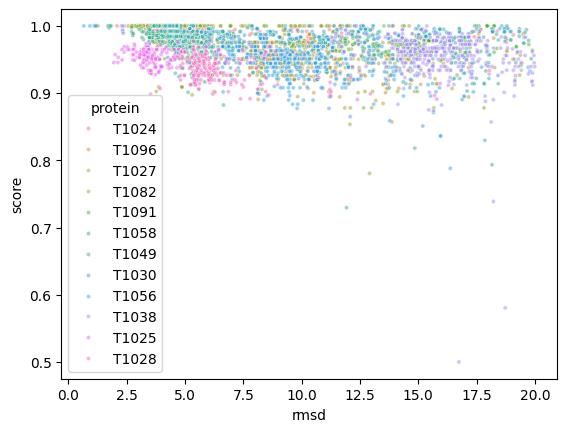

In [36]:
from scipy.stats import linregress
sns.scatterplot(data=das_filtered, x='rmsd', y='score', hue='protein', marker='.', alpha=0.5)
model = linregress(das_filtered.rmsd, das_filtered.score)
model.rvalue**2